<a href="https://colab.research.google.com/github/atick-faisal/Sign-Language-Recognition/blob/main/core/colab/ProjectionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown "1XG0u9AUABi_nKrWs5D4LGfP7v1KUFdD6"
!tar -xvf "lmc_dataset.tar.xz"

Downloading...
From: https://drive.google.com/uc?id=1XG0u9AUABi_nKrWs5D4LGfP7v1KUFdD6
To: /content/lmc_dataset.tar.xz
100% 26.3M/26.3M [00:00<00:00, 256MB/s]
X_test.joblib
X_train.joblib
y_test.joblib
y_train.joblib


In [2]:
import os
import math
import joblib
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm


# Configuration

In [3]:
class config(object):
    INFERENCE_TIME = 3.0  # ... Segment duration
    HOLD_TIME = 2.0  # ... Time before next prediction session
    SEGMENT_LEN = 256
    IMG_LEN = 224  # 1/9 of the 224x224 image
    N_CHANNELS = 1
    LEARNING_RATE = 0.001
    PROJECTION_LANDMARKS = ["rp", "rf0", "rf1"]
    INFERENCE_FEATURES = [
        "rpx",
        "rpy",
        "rpz",
        "rf0x",
        "rf0y",
        "rf0z",
        "rf1x",
        "rf1y",
        "rf1z"
    ]
    MODEL_PREDICTION = "dev.atick.slr.model.prediction"
    FRAME_EVENT = "dev.atick.slr.frame"
    GESTURES = ["Good", "Bad", "Fine", "Hello", "Yes", "Deaf", "Me",
                "No", "Please", "Sorry", "Thank You", "You", "Hungry", "Goodbye"]
    FEATURE_NAMES = [
        "time",
        "rpx",
        "rpy",
        "rpz",
        "lpx",
        "lpy",
        "lpz",
        "rf0x",
        "rf0y",
        "rf0z",
        "rf1x",
        "rf1y",
        "rf1z",
        "rf2x",
        "rf2y",
        "rf2z",
        "rf3x",
        "rf3y",
        "rf3z",
        "rf4x",
        "rf4y",
        "rf4z",
        "lf0x",
        "lf0y",
        "lf0z",
        "lf1x",
        "lf1y",
        "lf1z",
        "lf2x",
        "lf2y",
        "lf2z",
        "lf3x",
        "lf3y",
        "lf3z",
        "lf4x",
        "lf4y",
        "lf4z",
    ]


# Normalization

In [4]:
import numpy as np


def normalize(x: np.ndarray) -> np.ndarray:
    try:
        return (x - np.min(x)) / (np.max(x) - np.min(x))
    except ZeroDivisionError:
        return x


# Low-Pass Filter

In [5]:
import numpy as np
from scipy.signal import butter, lfilter


class LowPassFilter(object):
    def butter_lowpass(
        cutoff: int,
        fs: int,
        order: int
    ):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype="low", analog=False)
        return b, a

    def apply(
        data: np.ndarray,
        cutoff: int = 6,
        fs: int = 100,
        order: int = 2
    ):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order)
        y = lfilter(b, a, data)
        return y


# Spatical Projection

In [6]:
import os
import cv2
import numpy as np
import pandas as pd

from typing import List
from random import randint
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.ticker import NullLocator
from matplotlib.figure import Figure


class SpatialProjection():
    def __init__(
        self,
        img_dir: str,
        img_len: int,
        polyfit_degree: int = 0
    ):
        self.img_dir = img_dir
        self.img_len = img_len
        self.polyfit_degree = polyfit_degree

    @staticmethod
    def __write_image(
        img: np.ndarray,
        write_dir: str,
        plane: str,
        name: str
    ):
        path = os.path.join(write_dir, plane)
        if not os.path.exists(path):
            os.makedirs(path)
        cv2.imwrite(os.path.join(path, name + ".jpg"), img)

    def __get_preocessed_data(
        self,
        data: pd.Series
    ) -> np.ndarray:
        processed_data = data.to_numpy().ravel()

        if self.polyfit_degree == 0:
            # ... First few (10) datapoints contains filter artifacts
            processed_data = LowPassFilter.apply(processed_data)[10:]
        else:
            t = np.linspace(0, 1, processed_data.shape[0])
            f = np.poly1d(np.polyfit(t, processed_data, self.polyfit_degree))
            processed_data = f(t)

        return processed_data

    def __generate_projection_image(
        self,
        x: np.ndarray,
        y: np.ndarray
    ) -> np.ndarray:
        img_len_inch = self.img_len / 100.0  # 100 is the Figure DPI value
        fig = Figure(figsize=(img_len_inch, img_len_inch))
        width, height = fig.get_size_inches() * fig.get_dpi()

        canvas = FigureCanvas(fig)
        ax = fig.gca()
        ax.plot(x, y, "-k", linewidth=2)
        ax.axis("off")
        ax.xaxis.set_major_locator(NullLocator())
        ax.yaxis.set_major_locator(NullLocator())
        # fig.tight_layout()
        canvas.draw()

        image = np.frombuffer(canvas.tostring_rgb(), dtype="uint8")
        return image.reshape(int(height), int(width), 3)

    def get_projection_images(
        self,
        data: pd.DataFrame,
        subject: str,
        gesture: str,
        write_image: bool = False
    ) -> List[np.ndarray]:
        landmark = data.columns[0][:-1]
        name = str(randint(100000, 999999))
        write_dir = os.path.join(self.img_dir, subject, gesture, landmark)

        x = self.__get_preocessed_data(data.filter(regex="x"))
        y = self.__get_preocessed_data(data.filter(regex="y"))
        z = self.__get_preocessed_data(data.filter(regex="z"))

        img_xy = self.__generate_projection_image(x, y)
        img_yz = self.__generate_projection_image(y, z)
        img_zx = self.__generate_projection_image(z, x)

        if write_image == True:
            self.__write_image(img_xy, write_dir, "xy", name)
            self.__write_image(img_yz, write_dir, "yz", name)
            self.__write_image(img_zx, write_dir, "zx", name)

        return [img_xy, img_yz, img_zx]


# Setup

In [7]:
augmentation_levels = [0, 7, 9, 11, 13]
sp_augment = [
    SpatialProjection(
    img_dir="images/",
    img_len=math.floor(config.IMG_LEN / 3),
    polyfit_degree=degree
)
    for degree in augmentation_levels ]



In [8]:
X_train = joblib.load("X_train.joblib")
y_train = joblib.load("y_train.joblib")
X_test = joblib.load("X_test.joblib")
y_test = joblib.load("y_test.joblib")

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4535, 224, 224, 1)
(252, 224, 224, 1)
(4535,)
(252,)


# Pretrained Nets

In [9]:
# X_train = np.repeat(X_train, 3, axis=-1)
# X_test = np.repeat(X_test, 3, axis=-1)

# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# base_model = tf.keras.applications.MobileNetV2(
#     input_shape=(config.IMG_LEN, config.IMG_LEN, 3),
#     include_top=False,
#     weights="imagenet"
# )
# base_model.trainable = False
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(len(config.GESTURES))

# inputs = tf.keras.Input(shape=(config.IMG_LEN, config.IMG_LEN, 3))
# x = preprocess_input(inputs)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

# ViT

In [10]:
!pip install -U tensorflow-addons

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 144  # We'll resize input images to this size
patch_size = 12  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(factor=0.02),
        # layers.RandomZoom(
        #     height_factor=0.2, width_factor=0.2
        # ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(X_train)

def create_vit_classifier():
    inputs = layers.Input(shape=(224, 224, 1))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(len(config.GESTURES))(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

model = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ConvNet

In [11]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Rescaling(
#         1/255.0,
#         input_shape=(config.IMG_LEN, config.IMG_LEN, config.N_CHANNELS)
#     ),
#     tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(len(config.GESTURES))
# ])


# Training

In [12]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    )
]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
18/18 [==============================] - 26s 545ms/step - loss: 2.9754 - accuracy: 0.2620 - top-5-accuracy: 0.6503 - val_loss: 1.6224 - val_accuracy: 0.5595 - val_top-5-accuracy: 0.9405
Epoch 2/100
18/18 [==============================] - 7s 376ms/step - loss: 1.1608 - accuracy: 0.6271 - top-5-accuracy: 0.9270 - val_loss: 0.7997 - val_accuracy: 0.7738 - val_top-5-accuracy: 0.9643
Epoch 3/100
18/18 [==============================] - 7s 370ms/step - loss: 0.6941 - accuracy: 0.7841 - top-5-accuracy: 0.9709 - val_loss: 0.4862 - val_accuracy: 0.8770 - val_top-5-accuracy: 0.9881
Epoch 4/100
18/18 [==============================] - 7s 372ms/step - loss: 0.4392 - accuracy: 0.8639 - top-5-accuracy: 0.9846 - val_loss: 0.3751 - val_accuracy: 0.8968 - val_top-5-accuracy: 0.9802
Epoch 5/100
18/18 [==============================] - 7s 374ms/step - loss: 0.3425 - accuracy: 0.8805 - top-5-accuracy: 0.9850 - val_loss: 0.3390 - val_accuracy: 0.8929 - val_top-5-accuracy: 0.9841
Epoch 6/100
18

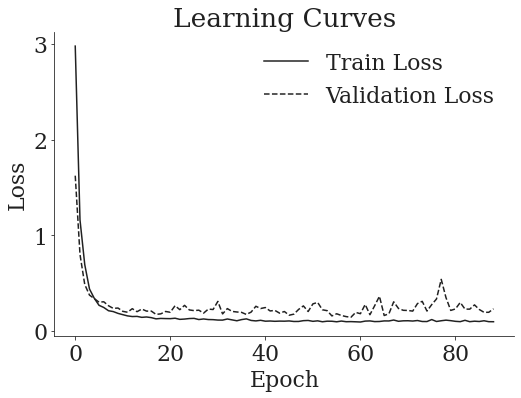

In [13]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 22,
    "text.color": "#212121",
    "axes.edgecolor": "#212121",
    "xtick.color": "#212121",
    "ytick.color": "#212121",
    "axes.labelcolor": "#212121",
    'legend.frameon': False,
})

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.plot(history.history["loss"], "-", color="#212121", label="Train Loss")
ax.plot(history.history["val_loss"], "--",
        color="#212121", label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Learning Curves")
plt.legend()
plt.tight_layout()
# plt.savefig("../assets/lc.png")
plt.show()


# Evaluation

In [14]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 27ms/step - loss: 0.1441 - accuracy: 0.9405 - top-5-accuracy: 0.9960


[0.14409616589546204, 0.9404761791229248, 0.9960317611694336]

In [15]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       1.00      0.87      0.93        15
           2       1.00      0.94      0.97        18
           3       1.00      0.84      0.91        19
           4       1.00      0.86      0.93        22
           5       1.00      0.94      0.97        16
           6       1.00      0.94      0.97        17
           7       1.00      1.00      1.00        17
           8       0.81      0.95      0.88        22
           9       1.00      1.00      1.00        22
          10       0.72      1.00      0.84        13
          11       0.91      1.00      0.95        21
          12       0.94      1.00      0.97        17
          13       0.89      0.94      0.92        18

    accuracy                           0.94       252
   macro avg       0.95      0.94      0.94       252
weighted avg       0.95      0.94      0.94       252



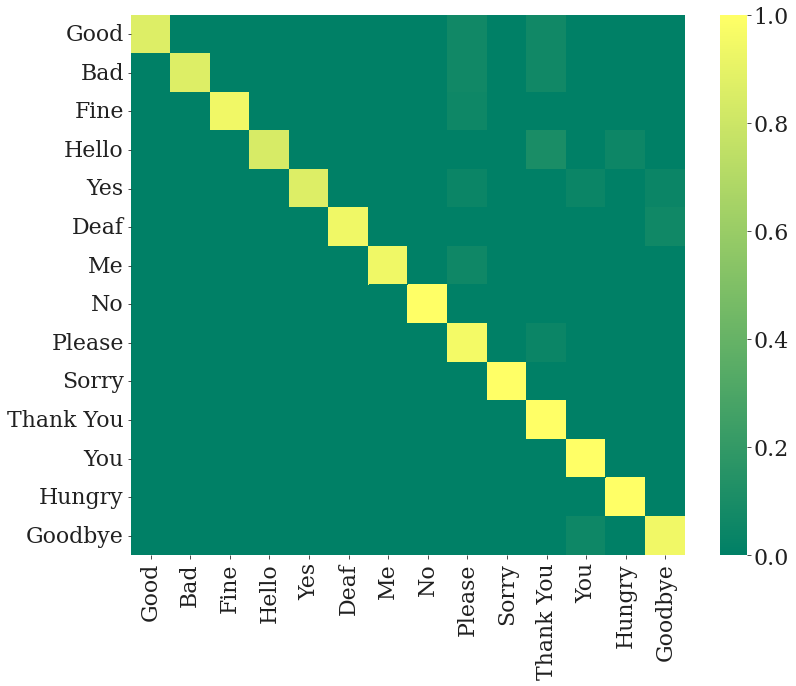

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(cm, cmap="summer")
plt.xticks(np.arange(len(config.GESTURES)) + 0.5, config.GESTURES, rotation=90)
plt.yticks(np.arange(len(config.GESTURES)) + 0.5, config.GESTURES, rotation=0)
plt.tight_layout()
plt.savefig("cm.svg")